# Exercise #4: Probabilistic Modelling of COVID-19 Mortality

### Probabilistic Machine Learning

- **Lecturer**: Prof. Philipp Hennig
- **Term**: SoSe 2020
- **Due Date**: Tuesday, 18 May 2020 at 10am

![https://marlin-prod.literatumonline.com/pb-assets/journals/trends/molecular-medicine/TRMOME-D-20-00044.pdf](figures/covid19_spread.png)

## COVID-19 Time-Series Data

**Task:** Download the number of confirmed infections and deaths by COVID-19 per million people from the following links:
- https://ourworldindata.org/grapher/total-confirmed-cases-of-covid-19-per-million-people
- https://ourworldindata.org/grapher/total-covid-deaths-per-million

Load the data from file and retrieve the infection and mortality statistics for the following countries
- Germany
- Italy
- France
- Great Britain
- Spain
- China
- USA

for further analysis.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

# Load data from file
infections_df = pd.read_csv("data/total-confirmed-cases-of-covid-19-per-million-people.csv")
deaths_df = pd.read_csv("data/total-covid-deaths-per-million.csv")

# Filter data for given countries
country_codes = ["DEU", "ITA", "FRA", "GBR", "ESP", "CHN", "USA"]
infections_df = infections_df.loc[infections_df["Code"].isin(country_codes)]
infections_df.columns = ["country", "code", "date", "infections per million"]
deaths_df = deaths_df.loc[deaths_df["Code"].isin(country_codes)]
deaths_df.columns = ["country", "code", "date", "deaths per million"]

# Convert dates to integer starting Dec 31, 2019
def daysfromdate(datestring, startdate="Dec 31, 2019"):
    """Return number of days from ``startdate`` given a date."""
    dayzero = datetime.strptime(startdate, '%b %d, %Y')
    dt = datetime.strptime(datestring, '%b %d, %Y')
    return (dt - dayzero).days

infections_df['date'] = infections_df['date'].apply(daysfromdate)
deaths_df['date'] = deaths_df['date'].apply(daysfromdate)

# Select data from February onward
day0 = 31
infections_df = infections_df.loc[infections_df["date"] > day0]
deaths_df = deaths_df.loc[deaths_df["date"] > day0]

# Pivot to long format
infections_df = infections_df.pivot(index="country", columns="date", values="infections per million")
deaths_df = deaths_df.pivot(index="country", columns="date", values="deaths per million")

# Fill NaNs with zeros
infections_df.fillna(value=0, inplace=True)
deaths_df.fillna(value=0, inplace=True)

# Display tables
# display(infections_df)
display(deaths_df.loc[:, 60:])

# Store each timeseries in the row of a numpy array
infections_permil = infections_df.to_numpy()
deaths_permil = deaths_df.to_numpy()

date,60,61,62,63,64,65,66,67,68,69,...,112,113,114,115,116,117,118,119,120,121
country,,,,,,,,,,,,,,,,,,,,,
China,1.971065,1.995381,2.024562,2.046795,2.072501,2.094039,2.114882,2.134336,2.153094,2.169074,...,3.220957,3.220957,3.220957,3.220957,3.220957,3.220957,3.221652,3.221652,3.221652,3.221652
France,0.030640,0.030640,0.030640,0.045960,0.061281,0.061281,0.107241,0.137881,0.153202,0.291083,...,310.462841,318.597841,326.932003,334.837200,340.796738,346.449874,350.157350,356.852256,362.474751,369.016455
Germany,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54.879249,58.233114,60.799238,63.508587,65.645035,67.316000,68.628900,70.574380,72.985343,75.050178
Italy,0.347327,0.479641,0.578878,0.860047,1.323149,1.769712,2.447825,3.258254,3.853671,6.053406,...,398.830151,407.662170,414.889871,422.564134,429.510666,436.374501,440.674734,446.182342,452.500378,457.842591
Spain,0.000000,0.000000,0.000000,0.000000,0.000000,0.021388,0.064165,0.106941,0.106941,0.106941,...,455.183377,464.487238,473.898039,481.747504,489.832238,495.992036,495.992036,509.509369,519.198218,0.000000
United Kingdom,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014731,0.014731,0.029461,0.044192,...,243.187093,255.384011,266.623441,276.021549,287.334632,299.310591,305.394320,310.697327,319.329445,384.423864
United States,0.000000,0.003021,0.006042,0.018127,0.027190,0.033232,0.036253,0.042296,0.051359,0.063444,...,128.515589,136.140905,141.340259,150.944412,154.128677,160.690558,165.787194,169.923112,176.297684,184.185838


## Probabilistic Model of Mortality

We build a simple probabilistic model for the number of infections and the mortality rate for COVID-19. Let 
$X_{ct} \in \mathbb{N}$ denote the latent number of *infected patients* per million people per country $c$ and time point $t$, $Y_{ct}  \in \mathbb{N}$ the number of *observed infections* per million people, $V_{ct}  \in \mathbb{N}$ the number of observed *fatalities* caused by COVID-19 per million, $\tau_c \in [0,1]$ the *testing rate* of infected patients for disease per country and $\rho \in [0,1]$ the *mortality rate* assumed to be constant across time and countries. The following probabilistic graphical model illustrates our setup.
![Probabilistic Graphical Model](figures/graphical_model.png)

**Task:** Making use of the (conditional) independence assumptions encoded in the model, derive the Markov blanket of each of the variables $X_{ct}$, $Y_{ct}$, $V_{ct}$, $\rho$ and $\tau_c$.

_Hint:_ The Markov blanket of a node is the minimal set of nodes in a graph when conditioned upon imply (conditional) independence of all other nodes in the graph, i.e. $\forall B \in V: \ P(A \mid \text{MB}(A), B) = P(A \mid \text{MB}(A))$

**Answer:** According to the d-separation rules, we obtain the following Markov blankets for the variables in the graphical model:
- Markov blanket for the variable $X_{ct}$ are all the other variables in the graphical model - $P(X_{ct} | V_{ct}, \rho, Y_{ct}, \tau_{c})$.
- Markov blanket for the variable $V_{ct}$ are the variables $X_{ct}$ and $\rho$ - $P(V_{ct} | X_{ct}, \rho)$.
- Markov blanket for the variable $Y_{ct}$ are the variables $X_{ct}$ and $\tau_{c}$ - $P(Y_{ct} | X_{ct}, \tau_{c})$.
- Markov blanket for the variable $\tau_{c}$ are the variables $Y_{ct}$ and $X_{ct}$ - $P(\tau_{c} | Y_{ct}, X_{ct})$.
- Markov blanket for the variable $\rho$ are the variables $V_{ct}$ and $X_{ct}$ - $P(\rho | V_{ct}, X_{ct})$.

---

We make the following assumptions in our probabilistic model. We observe the total number of tests performed and deaths occurred per day.
- $Y_{ct} = y_{ct}$
- $V_{ct} = v_{ct}$

We assume that our observations are corrupted by Gaussian noise given the latent number of infections, the mortality and the testing rate, respectively.
- $Y_{ct} \mid X_{ct}, \tau_c \sim \mathcal{N}(\tau_c X_{ct}, \sigma_y^2)$
- $V_{ct} \mid X_{ct}, \rho \sim \mathcal{N}(\rho X_{ct}, \sigma_v^2)$

where $\sigma_y^2 = 10^{-2}$ and $\sigma_v^2 = 10^{-4}$.

**Task:** What is the underlying assumed relationship between the observed infections $Y_{ct}$ and the observed deaths $V_{ct}$, if the observation noise collapses to zero for $\sigma_y^2 \rightarrow 0$ and $\sigma_v^2 \rightarrow 0$?

**Answer:** Since the noise collapses to $0$, $Y_{ct}$ is completely determined by $\tau_{c}$ and $X_{ct}$, and $V_{ct}$ is completely determined by $\rho$ and $X_{ct}$. That is, both values $Y_{ct}$ and $V_{ct}$ are functions of random variables.

$$
    Y_{ct} = \tau_{c} X_{ct}  \hspace{1cm}  V_{ct} = \rho X_{ct}
$$

The relationship between $Y_{ct}$ and $V_{ct}$ is
$$
    Y_{ct} = \dfrac{ \tau_{c} }{ \rho } V_{ct}  \hspace{1cm}  \text{or}  \hspace{1cm}  V_{ct} = \dfrac{ \rho }{ \tau_{c} } Y_{ct}
$$

---

We model the latent mortality rate as a Beta distribution depending on the latent number of cases and the observed fatalities. Assume the following parameterization
- $\rho \sim \text{Beta}\left(\sum_c V_{ct} + M_\rho \mu_\rho, \sum_c X_{ct} - \sum_c V_{ct} + M_\rho(1-\mu_\rho) \right)$,

where $\mu_\rho=0.05$ is the prior belief about the mortality before observing any data. This choice is motivated by the mortality of the flu (0.001) and SARS (0.1). The hyperparameter $M_\rho=1$ controls the strength of our prior belief about the mortality.

We put a Gaussian prior on the number of latent infections with a constant prior mean function $(\mu_x)_t = 10$ and variance $\sigma_x^2 = 0.1(\mu_x)_t$. modelling our belief over the progress of the disease before observing any actual cases.
- $X_{ct} \sim \mathcal{N}((\mu_x)_t, \sigma_x^2)$

Assuming we are given the observed infections and deaths, the testing and mortality rate, the current number of fatalities at time $t$, then the posterior over the latent number of infections according to our observational model is given by
- $X_{ct} \mid Y_{ct}, V_{ct}, \rho, \tau_c \sim \mathcal{N}(\mu_{ct}, \sigma_c^2)$,

where $\mu_{ct} = \big(\frac{\tau_c y_{ct}}{\sigma_y^2} +\frac{\rho v_{ct}}{\sigma_v^2} + \frac{(\mu_x)_t}{\sigma_x^2} \big)\sigma^{2}$ and $\sigma^2_{ct} =\big(\frac{\tau_c^2}{\sigma_y^2} +\frac{\rho^2}{\sigma_v^2} + \frac{1}{\sigma_x^2} \big)^{-1}$.

This can be derived as follows:
\begin{align}
p(X_{ct} \mid Y_{ct}, V_{ct}, \rho, \tau_c) &\propto p(X_{ct}, Y_{ct}, V_{ct} \mid \rho, \tau_c) = p(Y_{ct} \mid X_{ct}, \tau_c)p(V_{ct} \mid X_{ct}, \rho) p(X_{ct})\\
&=\mathcal{N}(Y_{ct}; \tau_c X_{ct}, \sigma_y^2)\mathcal{N}(V_{ct}; \rho X_{ct}, \sigma_v^2)\mathcal{N}(X_{ct}; (\mu_x)_t, \sigma_x^2)\\
&\propto \exp \bigg[ -\frac{1}{2} \Big(\big(\frac{\tau_c^2}{\sigma_y^2} +\frac{\rho^2}{\sigma_v^2} + \frac{1}{\sigma_x^2} \big)x_{ct}^2 - 2 \big(\frac{\tau_c y_{ct}}{\sigma_y^2} +\frac{\rho v_{ct}}{\sigma_v^2} + \frac{(\mu_x)_t}{\sigma_x^2} \big)x_{ct} \Big)\bigg]\\
&\propto \mathcal{N}(\mu_{ct}, \sigma_{ct}^2)
\end{align}



Finally, we estimate the per country testing rates also using a Beta distribution as above where the observations are given by the latent number of infections and the observed number of infections, like so
- $\tau_c \sim \text{Beta}\left(Y_{ct} + M_\tau \mu_\tau, X_{ct} - Y_{ct} + M_c(1-\mu_\tau) \right)$

where analoguously $\mu_\tau=0.1$ represents the prior belief about the testing rate, which we a priori assume to be the same across countries and $M_\tau=1$ controls the prior influence. Clearly, this assumption is very restrictive as it assumes that the testing rate is constant over time and we do not actually incorporate any data about how many people are tested relative to the entire population in our model. However we can hope to extract some information from the difference in testing rate across countries.

**Task:** Compute the expectation $\mathbb{E}[\rho]$ at a given time $t$. <font color="red">How does it behave for a large numbers of cases (and therefore fatalities)?</font>

**Answer:** The expectation $\mathbb{E}[\rho]$ is the expected value of a Beta distribution and for a general $\text{Beta}(a, b)$ is $\dfrac{a}{a + b}$. In our case, 
$$
    \rho \sim \text{Beta}\left(\sum_c V_{ct} + M_\rho \mu_\rho, \sum_c X_{ct} - \sum_c V_{ct} + M_\rho(1-\mu_\rho) \right)
$$

$$
    a = \sum_c V_{ct} + M_\rho \mu_\rho \hspace{1cm} b = \sum_c X_{ct} - \sum_c V_{ct} + M_\rho(1-\mu_\rho)
$$

Therefore
$$
    \mathbb{E}[\rho]
    = \dfrac{\sum_c V_{ct} + M_\rho \mu_\rho}{\sum_c V_{ct} + M_\rho \mu_\rho + \sum_c X_{ct} - \sum_c V_{ct} + M_\rho(1-\mu_\rho)}
    = \dfrac{\sum_c V_{ct} + M_\rho \mu_\rho}{\sum_c X_{ct} + M_\rho}
$$

If we subtitute the values $\mu_{\rho} = 0.05$ and $M_{\rho} = 1$, we get
$$
    \mathbb{E}[\rho]
    = \dfrac{\sum_c V_{ct} + 0.05}{\sum_c X_{ct} + 1}
$$

---

### Inference via Markov-Chain Monte-Carlo

We will now derive an inference procedure for our model based on the observed data. We will implement a Gibbs sampler, a form of Markov-Chain Monte-Carlo. To do so we need to be able to sample from the conditional distributions of every variable given all others.

**Task:** Based on the derived Markov blankets and model assumptions state the conditional distributions (and observed variables) needed to perform one iteration of the Gibbs sampler.

_Hint:_ If you had trouble deriving the Markov blankets, you can also read of conditional independence assumptions directly from the model description.

**Answer:** The conditional distributions needed to perform one iteration of the Gibbs sampler are:
- $P(X_{ct} | V_{ct}, \rho, Y_{ct}, \tau_{c}) \sim \mathcal{N}(\mu_{ct}, \sigma_c^2)$
- $P(V_{ct} | X_{ct}, \rho) \sim \mathcal{N}(\rho X_{ct}, \sigma_v^2)$
- $P(Y_{ct} | X_{ct}, \tau_{c}) \sim \mathcal{N}(\tau_c X_{ct}, \sigma_y^2)$ 
- $P(\tau_{c} | Y_{ct}, X_{ct}) \sim \text{Beta}\left(Y_{ct} + M_\tau \mu_\tau, X_{ct} - Y_{ct} + M_c(1-\mu_\tau) \right)$
- $P(\rho | V_{ct}, X_{ct}) \sim \text{Beta}\left(\sum_c V_{ct} + M_\rho \mu_\rho, \sum_c X_{ct} - \sum_c V_{ct} + M_\rho(1-\mu_\rho) \right)$

---

**Task:** Implement a Gibbs sampler to estimate the joint distribution of the latent variables given the observed number of infections and fatal cases over time.

#### Sequential implementation

In [2]:
import numpy as np
from tqdm import tqdm

def gibbs(y, v, burnin=50, samples=10000):
    """
    Gibbs sampler to infer parameters of the COVID-19 mortality model.
    
    Parameters
    ----------
    y : ndarray
        Observed infections.
    v : ndarray
        Observed fatalities.
    burnin : int
        Number of burn-in samples.
    samples : int
        Number of samples to draw.
    """
    # Setup
    _c, _t = y.shape
    
    sigma_y_2 = 1e-2
    sigma_v_2 = 1e-4
    
    # Initialize Gibbs sampler (by sampling from priors if necessary)
    rhos = np.zeros(_t)
    taus = np.zeros_like(y)
    Xs = np.zeros_like(y)
    
    vv = v[:, 0]
    yy = y[:, 0]
    
    # - Latent infections
    mu_x_t = 10
    sigma_x_2 = 0.1 * mu_x_t
    
    Xs[:, 0] = X = np.random.normal(loc=mu_x_t, scale=sigma_x_2, size=(_c))
    
    # - Mortality rate
    mu_rho = 0.05
    M_rho = 1
    
    a_rho = M_rho * mu_rho
    b_rho = M_rho * (1 - mu_rho)
    
    rho = np.random.beta(a_rho, b_rho)
    rho = np.expand_dims(rho, axis=0)
    rhos[0] = rho
    
    # - Testing rate
    mu_tau = 0.1
    M_tau = 1
    
    a_tau = M_tau * mu_tau
    b_tau = M_tau * (1 - mu_tau)
    tau = np.random.beta(a_tau, b_tau)
    
    taus[:, 0] = tau
    
    # Sample from conditional distributions
    for t in tqdm(range(1, _t)):
        rho = rhos[t-1]
        tau = taus[:, t-1]
        X = Xs[:, t-1]
        
        yy = y[:, t]
        vv = v[:, t]
        
        for _ in range(burnin):

            sigma_2 = 1 / ( ( tau ** 2 / sigma_y_2 ) + ( rho ** 2 / sigma_v_2 ) + ( 1 / sigma_x_2 ) )
            mu = ( (tau * yy / sigma_y_2) + (rho * vv / sigma_v_2) + (mu_x_t / sigma_x_2) )  #  * sigma_2

            Xs[:, t] = X = np.random.normal(loc=mu, scale=sigma_2, size=(_c))

        for _ in range(samples):

            # Testing rate
            a_tau = yy + M_tau * mu_tau
            b_tau = X - yy + M_tau * (1 - mu_tau)
            
            tau = np.random.beta(a_tau, b_tau)
            taus[:, t] = tau

            # Observations

            # Latent infections
            sigma_2 = 1 / ( ( tau ** 2 / sigma_y_2 ) + ( rho ** 2 / sigma_v_2 ) + ( 1 / sigma_x_2 ) )
            mu = ( (tau * yy / sigma_y_2) + (rho * vv / sigma_v_2) + (mu_x_t / sigma_x_2) ) #  * sigma_2

            Xs[:, t] = X = np.random.normal(loc=mu, scale=sigma_2, size=(_c))

            # Mortality
            a_rho = vv.sum() + M_rho * mu_rho
            b_rho = X.sum() - vv.sum() + M_rho * (1 - mu_rho)

            rho = np.random.beta(a_rho, b_rho)
            rho = np.expand_dims(rho, axis=0)
            rhos[t] = rho

    return {
        "rhos": rhos,
        "taus": taus,
        "v": v,
        "y": y,
        "Xs": Xs
    }


#### Batch implementation

In [3]:
def compute_rho_params(X, v, M_rho=1, mu_rho=0.05):
    a_rho = v.sum(axis=0) + M_rho * mu_rho
    b_rho = X.sum(axis=0) - v.sum(axis=0) + M_rho * (1 - mu_rho)
    return a_rho, b_rho

def compute_tau_params(X, y, M_tau=1, mu_tau=0.1):
    a_tau = y + M_tau * mu_tau
    b_tau = X - y + M_tau * (1 - mu_tau)
    return a_tau, b_tau

def compute_X_params(tau, y, rho, v, sigma_y_2=1e-2, sigma_v_2=1e-4, mu_x_t=10, sigma_x_2=None):
    if sigma_x_2 is None:
        sigma_x_2 = 0.1 * mu_x_t
    sigma_2 = 1 / ( ( tau ** 2 / sigma_y_2 ) + ( rho ** 2 / sigma_v_2 ) + ( 1 / sigma_x_2 ) )
    mu = ( (tau * y / sigma_y_2) + (rho * v / sigma_v_2) + (mu_x_t / sigma_x_2) ) * sigma_2
    return mu, sigma_2

In [4]:
# import numpy as np
# from tqdm import tqdm

# def gibbs(y, v, burnin=50, samples=10000):
#     """
#     Gibbs sampler to infer parameters of the COVID-19 mortality model.
    
#     Parameters
#     ----------
#     y : ndarray
#         Observed infections.
#     v : ndarray
#         Observed fatalities.
#     burnin : int
#         Number of burn-in samples.
#     samples : int
#         Number of samples to draw.
#     """
    
#     # Setup
#     _c, _t = y.shape
    
#     # Initialize Gibbs sampler (by sampling from priors if necessary)
    
#     # - Latent infections
#     mu_x_t = 10
#     X = np.random.normal(loc=mu_x_t, scale=0.1 * mu_x_t, size=(_c, _t))
    
#     for i, j in np.argwhere((X < y) | (X < v)):
#         while X[i, j] < y[i, j] or X[i, j] < v[i, j]:
#             X[i, j] = max(y[i, j], v[i, j]) + np.abs(np.random.normal(0, 1e-3))
# #             X[i, j] = np.random.normal(loc=mu_x_t, scale=sigma_x_2)
    
#     # - Mortality rate
#     a_rho, b_rho = compute_rho_params(np.zeros_like(X), np.zeros_like(v))
#     rho = np.random.beta(a_rho, b_rho)
#     rho = np.expand_dims(rho, axis=0)
    
#     # - Testing rate
#     a_tau, b_tau = compute_tau_params(np.zeros_like(X), np.zeros_like(y))
#     tau = np.random.beta(a_tau, b_tau)
        
# #     # Sample from conditional distributions
#     for _ in range(burnin):
         
# #         y = np.random.normal(loc=tau * X, scale=sigma_y_2)
# #         v = np.random.normal(loc=rho * X, scale=sigma_v_2)
         
#         mu, sigma_2 = compute_X_params(tau, y, rho, v)
#         X = np.random.normal(loc=mu, scale=sigma_2, size=(_c, _t))

#         for i, j in np.argwhere((X < y) | (X < v)):
#             while X[i, j] < y[i, j] or X[i, j] < v[i, j]:
#                 X[i, j] = max(y[i, j], v[i, j]) + np.abs(np.random.normal(0, 1e-3))
        
        
#     for _ in tqdm(range(samples)):  # http://users.stat.umn.edu/~geyer/mcmc/burn.html
        
#         # Testing rate
#         a_tau, b_tau = compute_tau_params(X, y)
#         tau = np.random.beta(a_tau, b_tau)

#         # Observations
# #         y = np.random.normal(loc=tau * X, scale=sigma_y_2)
# #         v = np.random.normal(loc=rho * X, scale=sigma_v_2)
        
#         # Latent infections
#         mu, sigma_2 = compute_X_params(tau, y, rho, v)
#         X = np.random.normal(loc=mu, scale=sigma_2, size=(_c, _t))
        
#         # Mortality
#         a_rho, b_rho = compute_rho_params(X, v)
#         rho = np.random.beta(a_rho, b_rho)
#         rho = np.expand_dims(rho, axis=0)

#     return {
#         "rhos": rho,
#         "taus": tau,
#         "v": v,
#         "y": y,
#         "Xs": X
#     }

### Mortality Rate

**Task:** Compute the posterior mean and 95% credible interval of the marginal distribution $p(\rho \mid Y_{ct}, V_{ct})$ for the mortality rate $\rho$ using the Gibbs sampler. Draw $100\,000$ samples to do so.

In [5]:
# Sampling
np.random.seed(1)

# Posterior mean of the mortality rate
results = gibbs(y=infections_permil, v=deaths_permil)

100%|██████████| 89/89 [01:05<00:00,  1.36it/s]


In [6]:
import scipy.stats

a_rho, b_rho = compute_rho_params(results["Xs"], results["v"])
rho_samples = np.random.beta(a_rho[-1], b_rho[-1], size=100000)

confidence = 0.95

n = len(rho_samples)
m, se = np.mean(rho_samples), scipy.stats.sem(rho_samples)
h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)

lb = m - h
ub = m + h

print(f"Mean value: {m:.7f} | Lower bound: {lb:.7f} | Upper bound: {ub:.7f}")

Mean value: 0.0035035 | Lower bound: 0.0035030 | Upper bound: 0.0035041


**Task:** Create scatterplots between the testing rate and mortality early on in time and towards the present for China, Germany and Italy. <font color="red">What do you observe? Do your observations match your expectation?</font>

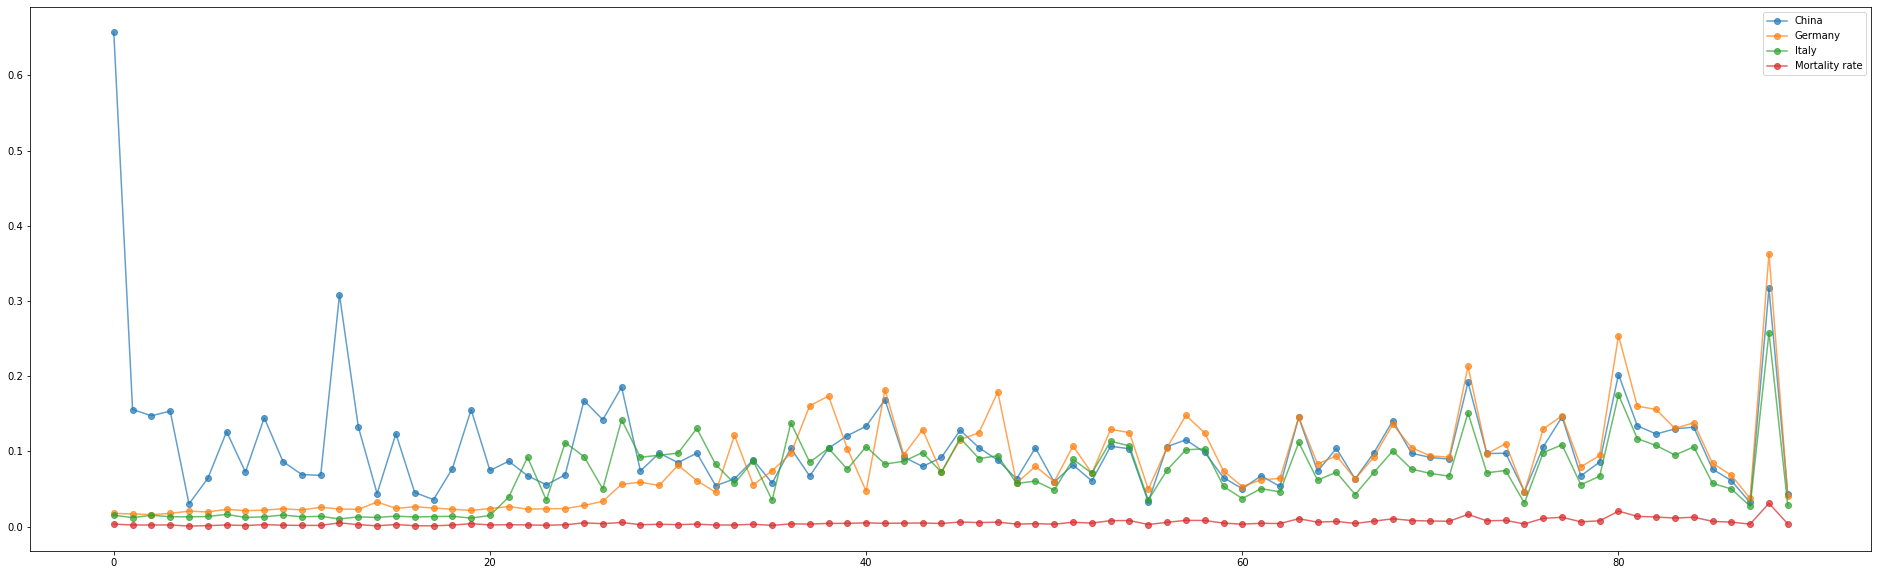

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot of testing rate versus mortality
a_tau, b_tau = compute_tau_params(results["Xs"], results["y"])
tau_mean = a_tau / (a_tau + b_tau)

a_rho, b_rho = compute_rho_params(results["Xs"], results["v"])
rho_mean = a_rho / (a_rho + b_rho)

style = '-o'
alpha_val = 0.70

plt.figure(figsize=(33, 10))
plt.plot(tau_mean.T[:, 0], style, alpha=alpha_val, label="China")
plt.plot(tau_mean.T[:, 2], style, alpha=alpha_val, label="Germany")
plt.plot(tau_mean.T[:, 3], style, alpha=alpha_val, label="Italy")
plt.plot(rho_mean.T, style, alpha=alpha_val, label="Mortality rate")
plt.legend()
plt.show()

**Answer:** <font color="red">...</font>

I expected the functions to be smoother than shown on the plot.

---

**Task:** Visualize the estimated mortality rate over time with its associated uncertainty based on the computed distribution. <font color="red">What do you observe? How does your estimate compare to the case fatality rate (CFR)? Are there differences and if yes why?</font>

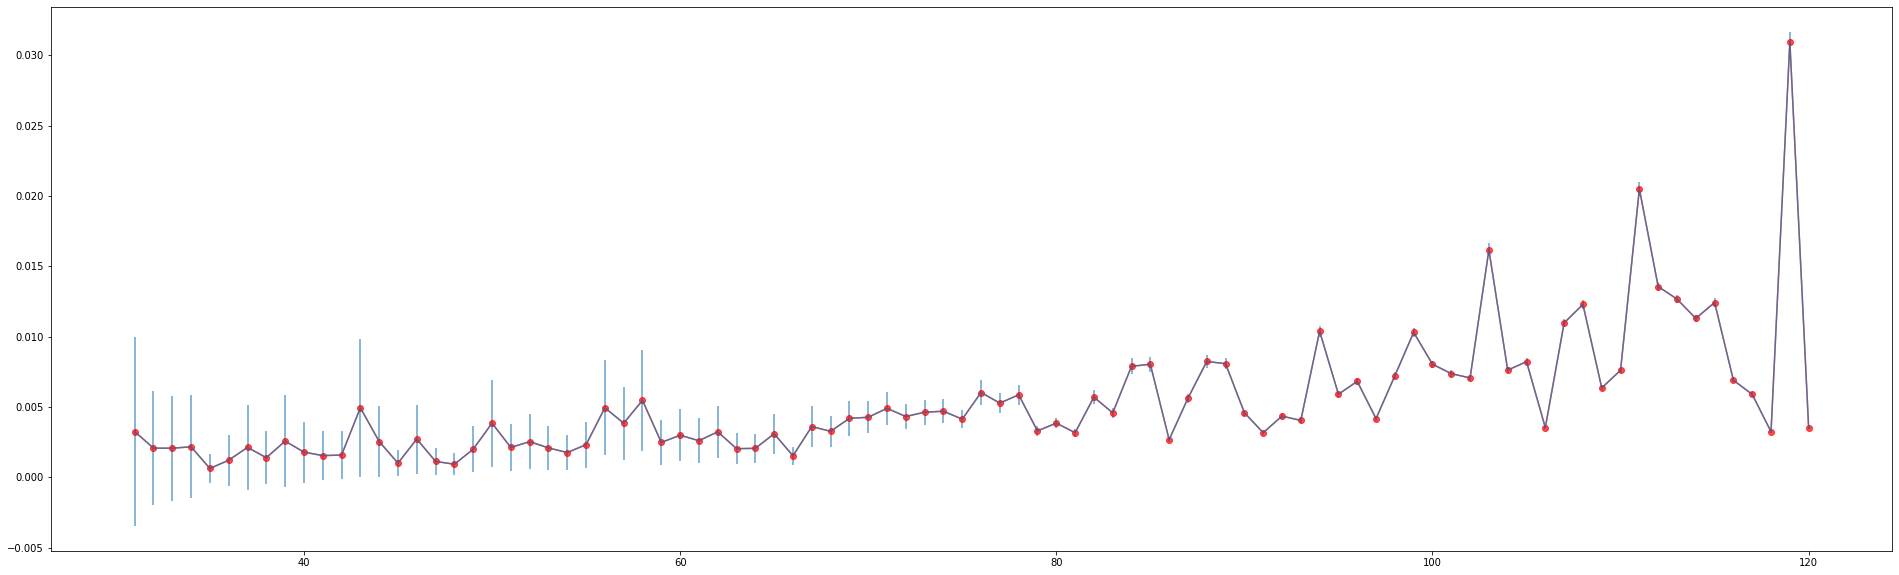

In [8]:
# Setup
days = np.arange(np.shape(infections_permil)[1]) + day0

# Plot
rhos_means = a_rho / (a_rho + b_rho)
rhos_se = np.sqrt((a_rho * b_rho) / ((a_rho + b_rho) ** 2 * (a_rho + b_rho + 1)))

plt.figure(figsize=(33, 10))
plt.plot(days, rhos_means, style, alpha=alpha_val, color="red")
plt.errorbar(days, rhos_means, rhos_se, alpha=alpha_val, fmt="")
plt.plot()
plt.show()

## Model Evaluation and Improvement

**Task:** What simplifying assumptions are you making in your model, which might be violated in reality?
- ...

**Task:** What can you say about the sensitivity of the model with regard to the testing rate $\tau$ and other parameter / prior choices?
- ...

**Task:** How would you improve the model? Describe a more realistic probabilistic model of COVID-19 mortality based on your findings above.
- The model does not incorporate the time dimension, which it definitely should since this is a time-series data.

**Image Sources**:
- Jiumeng Sun, Wanting He, Lifang Wang, et al. COVID-19: epidemiology, evolution, and cross-disciplinary perspectives. _Trends in Molecular Medicine_.

**References**:
-